#Proyecto Introduccion a la IA

Entrenamiento de la base de datos de Hotel booking demand

###Universidad de Antioquia
###Facultad de Ingeniería
###Ingeniería de Sistemas
###UdeA - Ude@
###Profesor: Raul Ramos Pollan

###Integrantes
###Nombre: Ramiro Monroy Ramos
###Cédula: 1027949562

Preparación y limpieza de datos.
La base de datos utilizada esta compuesta por dos conjuntos de datos; el primero es de el hotel resort (HR)y otro es un hotel urbano(HU).

##Instalación e importación de las librerias necesarias

In [ ]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import time
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
# Cargar la base de datos
db = pd.read_csv('hotel_bookings.csv')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
#Se limpia country por fuera del pipeline para que no quede agregado en el dataset final como categórico
db['country'].fillna(db['country'].mode()[0], inplace=True)
# Se eliminan las columnas que no tienen sentido para el entrenamiento
# La característica company se elimina porque solo existen 6797 valores de el total (119390) lo que corresponde a un porcentaje de faltante del 94.3%
# La característica reservation_status se elimina porque es una variable de salida
# La característica reservation_status_date se elimina porque es una fecha
db = db.drop(columns=['reservation_status', 'reservation_status_date','company'])
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
#Preparación del pipeline para entrenamiento

months= ['January','February','March', 'April', 'May', 'June'
        ,'July', 'August', 'September', 'October', 'November', 'December']


def procesar_con_onehotencoder(db):
    # Definir los transformadores
    #Imputer llena los valores nulos de las características children y agent con un valor 0. Son pocos los valores faltantes.
    #Para la característica agent falta un 13% de los datos. Para la característica children falta un 0.003% de los datos.
    #OrdinalEncoder le da un valor ordinal a los meses del año que se encuentran en la columna arrival_date_month.
    #OneHotEncoder convierte las variables categóricas a numéricas. No hay un orden específico.
    transformers = [
        ('imputer', SimpleImputer(strategy='constant', fill_value=0), ['children', 'agent'])
        ,('ordinal', OrdinalEncoder(categories=[months]), ['arrival_date_month'])
        ,('onehot', OneHotEncoder(sparse_output = False), ['hotel','country', 'meal', 'market_segment',
                                                           'distribution_channel','reserved_room_type',
                                                           'assigned_room_type','deposit_type','customer_type'])
    ]

    # Crear el ColumnTransformer
    preprocessor = ColumnTransformer(transformers, remainder='passthrough')

    # Crear el pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Aplicar el pipeline al DataFrame
    transformed_data = pipeline.fit_transform(db)

    #transformed_data.shape

    # Convertir los resultados en un nuevo DataFrame
    #transformed_df = pd.DataFrame(transformed_data)
    return transformed_data

def procesar_con_ordinalencoder(db):
    # Definir los transformadores
    #Imputer llena los valores nulos de las características children y agent con un 0. Son pocos los valores faltantes.
    #Para la característica agent falta un 13% de los datos. Para la característica children falta un 0.003% de los datos.
    #OrdinalEncoder le da un valor ordinal a los meses del año que se encuentran en la columna arrival_date_month.
    #LabelEncoder convierte las variables categóricas a numéricas. No hay un orden específico.
    transformers = [
        ('imputer', SimpleImputer(strategy='constant', fill_value=0), ['children', 'agent'])
        ,('ordinal', OrdinalEncoder(categories=[months]), ['arrival_date_month'])
        ,('labelencoder', OrdinalEncoder(), ['hotel','country', 'meal', 'market_segment',
                                                           'distribution_channel','reserved_room_type',
                                                           'assigned_room_type','deposit_type','customer_type'])
    ]

    # Crear el ColumnTransformer
    preprocessor = ColumnTransformer(transformers, remainder='passthrough')

    # Modelo para entrenamiento
    #svc = svm.SVC(decision_function_shape='ovr', kernel='rbf', C = 100, gamma=0.0001)

    # Crear el pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Aplicar el pipeline al DataFrame
    transformed_data = pipeline.fit_transform(db)

    # retornar los resultados
    return transformed_data

def procesar_con_ordinalencoder_estandarizado(db):
    # Definir los transformadores
    #Imputer llena los valores nulos de las características children y agent con un 0. Son pocos los valores faltantes.
    #Para la característica agent falta un 13% de los datos. Para la característica children falta un 0.003% de los datos.
    #OrdinalEncoder le da un valor ordinal a los meses del año que se encuentran en la columna arrival_date_month.
    #LabelEncoder convierte las variables categóricas a numéricas. No hay un orden específico.
    transformers = [
        ('imputer', SimpleImputer(strategy='constant', fill_value=0), ['children', 'agent'])
        ,('ordinal', OrdinalEncoder(categories=[months]), ['arrival_date_month'])
        ,('labelencoder', OrdinalEncoder(), ['hotel','country', 'meal', 'market_segment',
                                                           'distribution_channel','reserved_room_type',
                                                           'assigned_room_type','deposit_type','customer_type'])
    ]

    # Crear el ColumnTransformer
    preprocessor = ColumnTransformer(transformers, remainder='passthrough')

    # Modelo para entrenamiento
    #svc = svm.SVC(decision_function_shape='ovr', kernel='rbf', C = 100, gamma=0.0001)

    # Crear el pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Aplicar el pipeline al DataFrame
    transformed_data = pipeline.fit_transform(db)

    #Aplicar estandarización
    scaler = MinMaxScaler()

    standardized_data = scaler.fit_transform(transformed_data)
    # retornar los resultados
    return standardized_data

In [ ]:
datosX = db.drop('is_canceled', axis=1)

Y = np.asarray(db['is_canceled'])

# Se toman 30.000 muestras debido que la capacidad de la maquina no permite trabajar con todas las muestras
sampled_indices = np.random.choice(range(len(X)), size=30000, replace=False)
X_sampled = procesar_con_ordinalencoder_estandarizado(datosX)[sampled_indices]
Y_sampled = Y[sampled_indices]

print(X_sampled.shape)
print(Y_sampled.shape)



(30000, 28)
(30000,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# Definir los modelos
svm_model = svm.SVC()
rf_model = RandomForestClassifier()

# Reducción del espacio de búsqueda de hiperparámetros
param_grid_svm = {'C': [0.1], 'gamma': [0.1]}
param_grid_rf = {'n_estimators': [50], 'max_depth': [None]}

# Realizar la búsqueda aleatoria para SVM
random_search_svm = RandomizedSearchCV(svm_model, param_distributions=param_grid_svm, n_iter=5, cv=5)
random_search_svm.fit(X_sampled, Y_sampled)

# Mostrar los mejores parámetros para SVM
print("Mejores hiperparámetros para SVM:", random_search_svm.best_params_)

# Realizar la búsqueda aleatoria para RandomForest
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf, n_iter=5, cv=5)
random_search_rf.fit(X_sampled, Y_sampled)

# Mostrar los mejores parámetros para RandomForest
print("Mejores hiperparámetros para RandomForest:", random_search_rf.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros para SVM: {'gamma': 0.1, 'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros para RandomForest: {'n_estimators': 50, 'max_depth': None}


In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_sampled, test_size=0.2, random_state=42)

# Combinación 1: PCA + SVM
pca_model = PCA()
svm_model = SVC()

# Definir los parámetros a buscar para PCA y SVM
param_grid_pca_svm = {'pca__n_components': [5, 10, 15], 'svm__C': [0.1, 1, 10], 'svm__gamma': [0.01, 0.1, 1]}

# Crear el pipeline para la combinación de PCA y SVM
pipeline_pca_svm = Pipeline(steps=[('pca', pca_model), ('svm', svm_model)])

# Realizar la búsqueda aleatoria para PCA y SVM
random_search_pca_svm = RandomizedSearchCV(pipeline_pca_svm, param_distributions=param_grid_pca_svm, n_iter=5, cv=5)
random_search_pca_svm.fit(X_train, Y_train)

# Mostrar los mejores parámetros para PCA y SVM
print("Mejores hiperparámetros para PCA + SVM:", random_search_pca_svm.best_params_)

# Combinación 2: LDA + RandomForest
lda_model = LDA()
rf_model = RandomForestClassifier()

# Definir los parámetros a buscar para LDA y RandomForest
param_grid_lda_rf = {'lda__n_components': [None], 'rf__n_estimators': [50], 'rf__max_depth': [None]}

# Crear el pipeline para la combinación de LDA y RandomForest
pipeline_lda_rf = Pipeline(steps=[('lda', lda_model), ('rf', rf_model)])

# Realizar la búsqueda aleatoria para LDA y RandomForest
random_search_lda_rf = RandomizedSearchCV(pipeline_lda_rf, param_distributions=param_grid_lda_rf, n_iter=5, cv=5)
random_search_lda_rf.fit(X_train, Y_train)

# Mostrar los mejores parámetros para LDA y RandomForest
print("Mejores hiperparámetros para LDA + RandomForest:", random_search_lda_rf.best_params_)



Mejores hiperparámetros para PCA + SVM: {'svm__gamma': 1, 'svm__C': 1, 'pca__n_components': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros para LDA + RandomForest: {'rf__n_estimators': 50, 'rf__max_depth': None, 'lda__n_components': None}


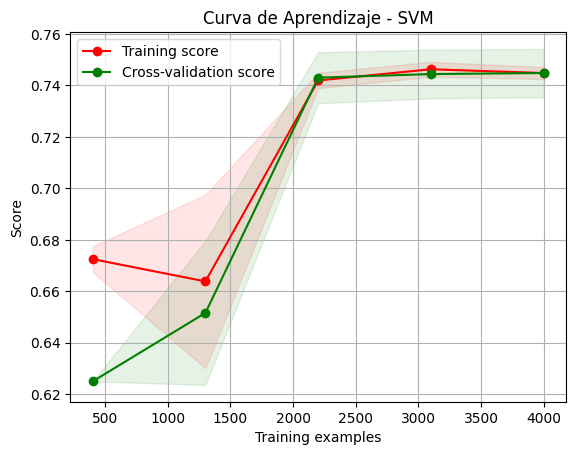

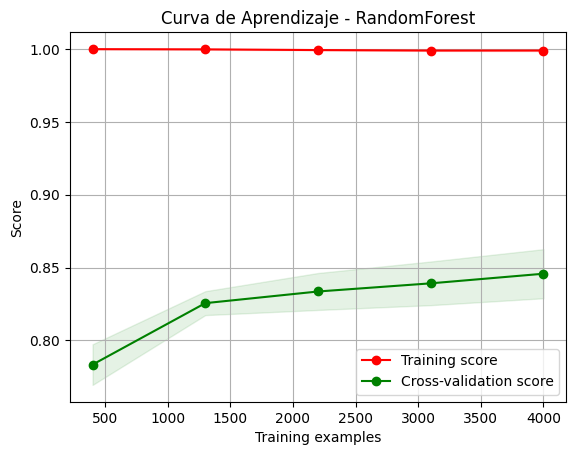

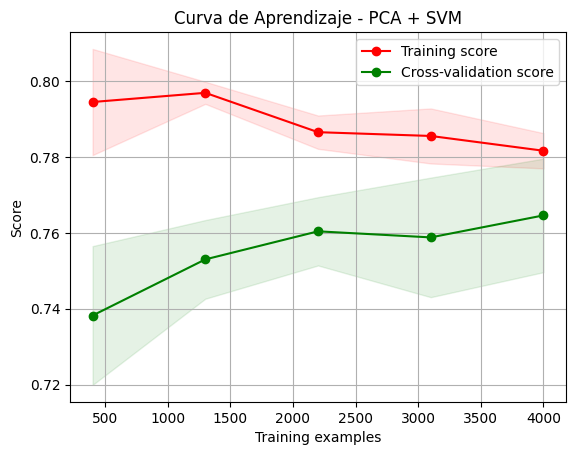

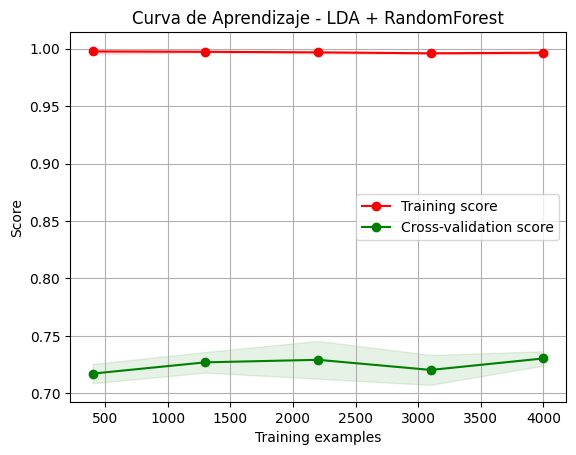

In [ ]:

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Ajustar el tamaño del conjunto de datos para la curva de aprendizaje
X_sampled_lc = X_sampled[:5000]
Y_sampled_lc = Y_sampled[:5000]

# Ajustar los estimadores con los mejores hiperparámetros encontrados
best_svm_model = svm.SVC(**random_search_svm.best_params_)
best_rf_model = RandomForestClassifier(**random_search_rf.best_params_)
best_pca_svm_model = pipeline_pca_svm.set_params(**random_search_pca_svm.best_params_)
best_lda_rf_model = pipeline_lda_rf.set_params(**random_search_lda_rf.best_params_)

# Mostrar las curvas de aprendizaje para cada caso
plot_learning_curve(best_svm_model, "Curva de Aprendizaje - SVM", X_sampled_lc, Y_sampled_lc, cv=5, n_jobs=-1)
plt.show()

plot_learning_curve(best_rf_model, "Curva de Aprendizaje - RandomForest", X_sampled_lc, Y_sampled_lc, cv=5, n_jobs=-1)
plt.show()

plot_learning_curve(best_pca_svm_model, "Curva de Aprendizaje - PCA + SVM", X_sampled_lc, Y_sampled_lc, cv=5, n_jobs=-1)
plt.show()

plot_learning_curve(best_lda_rf_model, "Curva de Aprendizaje - LDA + RandomForest", X_sampled_lc, Y_sampled_lc, cv=5, n_jobs=-1)
plt.show()


**EVALUACIÓN DIAGNOSTICA**

**Modelo SVM con Mejores Hiperparámetros:**

**Diagnóstico:**

Es posible que el modelo SVM esté propenso a overfitting debido a la naturaleza de los hiperparámetros seleccionados ('gamma': 0.1, 'C': 0.1).

**Recomendación:**

Se podría considerar una búsqueda más exhaustiva de hiperparámetros y técnicas de regularización para reducir el riesgo de overfitting.
También se puede explorar la posibilidad de utilizar un conjunto de datos más grande para el entrenamiento.

**Modelo Random Forest con Mejores Hiperparámetros:**

**Diagnóstico:**

El modelo Random Forest utiliza 'n_estimators': 50 y 'max_depth': None como mejores hiperparámetros, lo que podría llevar a un modelo complejo.

**Recomendación:**

Se podría explorar una búsqueda más amplia de hiperparámetros y considerar limitar la profundidad máxima del árbol para evitar overfitting.
La optimización de la cantidad de árboles también podría ser beneficiosa.

**Combinación PCA + SVM con Mejores Hiperparámetros:**

**Diagnóstico:**

La combinación de PCA y SVM utiliza 'svm__gamma': 1, 'svm__C': 1, 'pca__n_components': 10 como mejores hiperparámetros.

**Recomendación:**

Se podría explorar la posibilidad de ajustar la cantidad de componentes principales (PCA) para verificar si hay mejoras adicionales.
Considerar la exploración de otros algoritmos de reducción de dimensionalidad.

**Combinación LDA + Random Forest con Mejores Hiperparámetros:**

**Diagnóstico:**

La combinación de LDA y Random Forest utiliza 'rf__n_estimators': 50, 'rf__max_depth': None, 'lda__n_components': None como mejores hiperparámetros.

**Recomendación:**

Se podría investigar el impacto de ajustar los hiperparámetros de LDA, especialmente la cantidad de componentes, para mejorar el rendimiento.
La optimización de los hiperparámetros de RandomForest también puede ser útil.

**Despliegue en Producción:**

**Establecimiento del Nivel de Desempeño Mínimo:**

Establecer un nivel mínimo de desempeño dependerá de los requisitos comerciales y las expectativas del usuario. Se podrían definir métricas específicas, como precisión, recall o F1-score, que el modelo debe cumplir antes de ser desplegado.

**Despliegue en Producción:**

El despliegue en producción puede realizarse mediante la implementación de servicios web o contenedores. Se deben seguir las mejores prácticas de seguridad y escalabilidad.
Utilizar herramientas como Docker y Kubernetes puede facilitar el despliegue y la administración de modelos en entornos de producción.

**Procesos de Monitoreo del Desempeño en Producción:**

Implementar un sistema de monitoreo continuo para evaluar el desempeño del modelo en tiempo real.
Registrar métricas clave como precisión, recall y F1-score.
Establecer alertas para notificar cualquier degradación en el rendimiento.
Realizar actualizaciones periódicas del modelo para mantener la eficacia a medida que los datos cambian con el tiempo.

**Retos y Consideraciones:**

Reto: Mantener la calidad de los datos en producción.

Solución: Implementar procesos de monitoreo de datos para asegurar la consistencia y calidad de los datos de entrada.

Reto: Escalabilidad y rendimiento.

Solución: Utilizar arquitecturas de sistemas que permitan escalabilidad horizontal y vertical, y realizar pruebas de carga antes del despliegue.

Reto: Interpretabilidad del modelo.

Solución: Utilizar técnicas de explicabilidad de modelos para comprender y comunicar las decisiones del modelo a las partes interesadas.

**Conclusión:**

Mejorar el desempeño del modelo podría implicar una exploración más profunda de los hiperparámetros, la consideración de otros algoritmos y la optimización de la cantidad de datos de entrenamiento.
El despliegue en producción requerirá una cuidadosa planificación y monitoreo continuo para garantizar que el modelo mantenga su eficacia con el tiempo.